# Dogs Skin Disease Prediction Model

In [25]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

base_dir = Path("Dataset")
IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 8

## Preprocessing 

### Data Augmentation

In [27]:
train_datagen = ImageDataGenerator(
   rescale=1.0/255,
   rotation_range=40,
   width_shift_range=0.3,
   height_shift_range=0.3,
   shear_range=0.3,
   zoom_range=0.3,
   horizontal_flip=True,
   vertical_flip=True,
   brightness_range=[0.7,1.3],
   channel_shift_range=50,
   fill_mode='nearest',
   validation_split=0.2
)

### Multiple Augmented Versions

In [29]:
def augment_directory(source_dir, num_augmented=5):
   for class_dir in source_dir.iterdir():
       if not (class_dir / 'augmented').exists():
            augment_directory(base_dir)
       if class_dir.is_dir():
           aug_dir = class_dir / 'augmented'
           aug_dir.mkdir(exist_ok=True)
           
           for img_path in class_dir.glob('*.[jp][pn][g]'):
               img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
               x = img_to_array(img)
               x = x.reshape((1,) + x.shape)
               
               i = 0
               for batch in train_datagen.flow(x, batch_size=1,
                                             save_to_dir=aug_dir,
                                             save_prefix=f'aug_{img_path.stem}',
                                             save_format='jpg'):
                   i += 1
                   if i >= num_augmented:
                       break

### Creating generators

In [23]:
#Creating generators
train_generator = train_datagen.flow_from_directory(
   base_dir,
   target_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   subset='training'
)

validation_generator = train_datagen.flow_from_directory(
   base_dir,
   target_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   class_mode='categorical', 
   subset='validation'
)

NameError: name 'IMG_HEIGHT' is not defined

In [11]:
print("Classes:", train_generator.class_indices)
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)

Found 438 images belonging to 5 classes.
Found 106 images belonging to 5 classes.
Classes: {'Allergies': 0, 'Autoimmune': 1, 'Healthy': 2, 'Infections': 3, 'Parasites': 4}
Training samples: 438
Validation samples: 106


## Model Training and Evaluation

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import json

### Getting all images and labels 

As we have augmented images we need to collect the data from both 

In [ ]:
#Preparing data generators that include both original and augmented images
all_data = []
all_labels = []

#Collecting data from original and augmented images
for class_dir in base_dir.iterdir():
    if class_dir.is_dir():
        class_label = class_dir.name
        class_index = train_generator.class_indices[class_label]
        
        #Processing original images
        for img_path in class_dir.glob('*.[jp][pn][g]'):
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            x = img_to_array(img)
            x = x / 255.0  # Normalize
            all_data.append(x)
            label = np.zeros(len(train_generator.class_indices))
            label[class_index] = 1
            all_labels.append(label)
        
        #Processing augmented images
        aug_dir = class_dir / 'augmented'
        if aug_dir.exists():
            for img_path in aug_dir.glob('*.[jp][pn][g]'):
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                x = img_to_array(img)
                x = x / 255.0  # Normalize
                all_data.append(x)
                label = np.zeros(len(train_generator.class_indices))
                label[class_index] = 1
                all_labels.append(label)

all_data = np.array(all_data)
all_labels = np.array(all_labels)

### Creating the model

In [ ]:
#Initializing model and training parameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0
best_fold = None
accuracies = []
fold = 1

In [ ]:
#Creating model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Training the model with k-fold Cross-Validation

In [ ]:
#Training with cross-validation
for train_index, val_index in kf.split(all_data):
    print(f"Training Fold {fold}...")
    x_train, x_val = all_data[train_index], all_data[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]
    
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )
    
    eval_result = model.evaluate(x_val, y_val, verbose=0)
    accuracies.append(eval_result[1])
    print(f"Fold {fold} Accuracy: {eval_result[1]}")
    
    if eval_result[1] > best_accuracy:
        best_accuracy = eval_result[1]
        best_fold = fold
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())
    
    fold += 1


In [ ]:
print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print(f"Best Fold: {best_fold} with Accuracy: {best_accuracy}")

### Saving the best model in a keras file

In [ ]:
if best_model is not None:
    best_model.save('best_model.keras')
    print("Best model saved as 'best_model.keras'")

with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)
    print("Class indices saved as 'class_indices.json'")

### Evaluating the model

In [ ]:
#Confusion Matrix
y_pred = best_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
           xticklabels=train_generator.class_indices.keys(),
           yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

/var/folders/ys/ndlktzd129z_51vvh7tqhc8m0000gn/T/ipykernel_66215/2656963688.py:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


Training Fold 1...
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3353 - loss: 1.8595 - val_accuracy: 0.7222 - val_loss: 0.9357
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6238 - loss: 0.9958 - val_accuracy: 0.7222 - val_loss: 0.7544
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7160 - loss: 0.7604 - val_accuracy: 0.7315 - val_loss: 0.6404
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8571 - loss: 0.4550 - val_accuracy: 0.8426 - val_loss: 0.4968
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8669 - loss: 0.3963 - val_accuracy: 0.8796 - val_loss: 0.4319
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9050 - loss: 0.2772 - val_accuracy: 0.8611 - val_loss: 0.4143
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9342 - loss: 0.2303 - val_accuracy: 0.8519 - val_loss: 0.3787
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9554 - loss: 0.1812 - val_a

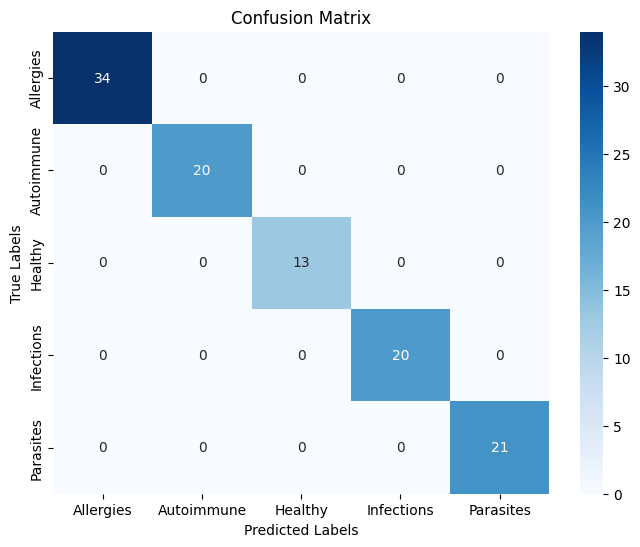


Classification Report:
              precision    recall  f1-score   support

   Allergies       1.00      1.00      1.00        34
  Autoimmune       1.00      1.00      1.00        20
     Healthy       1.00      1.00      1.00        13
  Infections       1.00      1.00      1.00        20
   Parasites       1.00      1.00      1.00        21

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



In [13]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
     target_names=train_generator.class_indices.keys()))